(mc)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`有限马尔可夫链 <single: Finite Markov Chains>`

```{contents} 目录
:depth: 2
```

除了Anaconda中已有的库外，本讲座还需要以下库：

In [1]:
!pip install quantecon

## 概述

马尔可夫链是一类最实用的随机过程，它们之所以重要是因为：

* 它们结构简单且灵活，同时有着丰富而优雅的理论基础
* 它们能帮助我们直观理解随机动态模型
* 它们在定量建模中扮演着核心角色

在经济学和金融学领域，许多基础模型都采用了马尔可夫链。

本讲座将回顾马尔可夫链的基本理论。

我们还将介绍[QuantEcon.py](https://quantecon.org/quantecon-py/)库中提供的一些处理马尔可夫链的高效工具。

学习本讲座需要具备基本的概率论和线性代数知识。

首先，让我们导入需要的库：

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import quantecon as qe
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

## 定义

让我们先介绍一些基本概念。

(finite_dp_stoch_mat)=
### {index}`随机矩阵 <single: Stochastic Matrices>`

```{index} single: Finite Markov Chains; Stochastic Matrices
```

**随机矩阵**（或**马尔可夫矩阵**）是一个 $n \times n$ 的方阵 $P$，满足：

1. $P$ 的每个元素都是非负的，且
1. $P$ 的每一行之和等于一

$P$ 的每一行都可以被视为在 $n$ 个可能结果上的概率质量函数。

不难证明[^pm]，如果 $P$ 是随机矩阵，那么对于所有 $k \in \mathbb N$，其 $k$ 次幂 $P^k$ 也是随机矩阵。

### {index}`马尔可夫链 <single: Markov Chains>`

```{index} single: Finite Markov Chains
```

随机矩阵与马尔可夫链有着紧密的关系。

让我们考虑一个有限集 $S$，它包含 $n$ 个元素 $\{x_1, \ldots, x_n\}$。

我们称 $S$ 为**状态空间**，其中的元素 $x_1, \ldots, x_n$ 称为**状态**。

**马尔可夫链** $\{X_t\}$ 是一个在状态空间 $S$ 上取值的随机变量序列，它具有**马尔可夫性质**。

马尔可夫性质表明，对于任意时间 $t$ 和任意状态 $y \in S$，

```{math}
:label: fin_markov_mp

\mathbb P \{ X_{t+1} = y  \,|\, X_t \}
= \mathbb P \{ X_{t+1}  = y \,|\, X_t, X_{t-1}, \ldots \}
```

换句话说，只要知道当前状态，就足以预测未来状态的概率分布，而不需要知道过去的历史。

具体来说，马尔可夫链的整个动态行为完全由以下条件概率集合决定

```{math}
:label: mpp

P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \}
\qquad (x, y \in S)
```

根据定义，

* $P(x, y)$ 表示系统在一个时间步内从状态 $x$ 转移到状态 $y$ 的概率
* $P(x, \cdot)$ 表示当当前状态为 $X_t = x$ 时，下一状态 $X_{t+1}$ 的条件概率分布

我们可以将这些转移概率组织成一个随机矩阵 $P$，其中

$$
P_{ij} = P(x_i, x_j)
\qquad 1 \leq i, j \leq n
$$

反过来，给定一个随机矩阵 $P$，我们可以构造一个马尔可夫链 $\{X_t\}$，具体方法是：

* 从某个初始分布 $\psi$ 中抽取初始状态 $X_0$
* 对于每个时间 $t = 0, 1, \ldots$，根据条件分布 $P(X_t,\cdot)$ 随机生成下一状态 $X_{t+1}$

通过这种构造方式，我们得到的随机过程自然满足马尔可夫性质 {eq}`mpp`。

(mc_eg1)=
### 示例1

让我们考虑一个劳动者的就业状态，在任何给定时间 $t$，该劳动者要么处于失业状态（状态0）要么处于就业状态（状态1）。

假设在一个月的时间内：

1. 一个失业劳动者找到工作的概率是 $\alpha \in (0, 1)$。
2. 一个就业劳动者失去工作的概率是 $\beta \in (0, 1)$。

在马尔可夫链模型中，我们有：

* 状态空间 $S = \{ 0, 1\}$
* 转移概率 $P(0, 1) = \alpha$ 和 $P(1, 0) = \beta$

我们可以将这些转移概率表示为一个矩阵：

```{math}
:label: p_unempemp

P
= \left(
\begin{array}{cc}
    1 - \alpha & \alpha \\
    \beta & 1 - \beta
\end{array}
  \right)
```

有了 $\alpha$ 和 $\beta$ 的值后，我们可以回答许多有趣的问题，例如：

* 一个人平均会失业多长时间？
* 长期来看，一个劳动者有多大比例的时间处于失业状态？
* 如果一个人现在有工作，那么在未来一年内他至少失业一次的概率是多少？

我们将在后续章节中详细探讨这些应用。

(mc_eg2)=
### 示例2

Hamilton {cite}`Hamilton2005` 基于美国失业数据估计了以下随机矩阵

$$
P =
\left(
  \begin{array}{ccc}
     0.971 & 0.029 & 0 \\
     0.145 & 0.778 & 0.077 \\
     0 & 0.508 & 0.492
  \end{array}
\right)
$$

在这个模型中：

* 数据频率是月度的
* 状态1表示"正常增长"阶段
* 状态2表示"轻度衰退"阶段
* 状态3表示"严重衰退"阶段

从矩阵中我们可以看出，如果经济当前处于正常增长阶段，那么下个月仍然保持正常增长的概率高达0.971。

注意矩阵主对角线上的元素普遍较大，这表明经济状态往往具有一定的持续性——当经济处于某一特定状态时，它倾向于在该状态停留一段时间。

这个马尔可夫链也可以通过下面的有向图来直观表示，图中的箭头上标注了相应的转移概率：

```{figure} /_static/lecture_specific/finite_markov/hamilton_graph.png
```

这里"ng"表示正常增长，"mr"表示温和衰退，等等。

## 模拟

```{index} single: Markov Chains; Simulation
```

研究马尔可夫链问题的一种直观方法是通过模拟。

(如果我们想估计某个事件 $E$ 发生的概率，可以进行大量模拟，然后计算事件 $E$ 在这些模拟中出现的频率)。

[QuantEcon.py](http://quantecon.org/quantecon-py)库提供了强大的马尔可夫链模拟工具。

* 这些工具不仅高效，还包含了许多处理马尔可夫链的实用函数。

不过，自己动手编写模拟程序也是一个很好的学习过程——我们先尝试自己实现，然后再介绍[QuantEcon.py](http://quantecon.org/quantecon-py)的方法。

在接下来的练习中，我们将状态空间定义为 $S = 0,\ldots, n-1$。

### 自己编写模拟程序

要模拟马尔可夫链，我们需要两个基本要素：转移概率矩阵 $P$ 和一个初始概率分布 $\psi$，用来确定初始状态 $X_0$。

马尔可夫链的模拟过程可以概括为：

1. 在初始时刻 $t=0$，根据分布 $\psi$ 随机生成初始状态 $X_0$。
2. 对于每个后续时刻 $t$，根据当前状态 $X_t$ 对应的转移概率行 $P(X_t, \cdot)$ 随机生成下一个状态 $X_{t+1}$。

为了实现这个过程，我们需要一种从离散概率分布中抽样的方法。

我们将使用 [QuantEcon](http://quantecon.org/quantecon-py) 库中的 `random.draw` 函数，它的用法如下：

In [3]:
ψ = (0.3, 0.7)           # {0, 1}上的概率
cdf = np.cumsum(ψ)       # 转换为累积分布
qe.random.draw(cdf, 5)   # 从ψ中生成5个独立抽样

array([1, 1, 0, 1, 1])

我们将编写一个函数，它接受以下三个参数：

* 一个随机矩阵 `P`（表示转移概率矩阵）
* 一个初始概率分布 `ψ_0`（用于确定初始状态）
* 一个正整数 `sample_size`（表示要生成的马尔可夫链时间序列长度）

In [4]:
def mc_sample_path(P, ψ_0=None, sample_size=1_000):

    # 设置
    P = np.asarray(P)
    X = np.empty(sample_size, dtype=int)

    # 将P的每一行转换为累积分布函数
    n = len(P)
    P_dist = [np.cumsum(P[i, :]) for i in range(n)]

    # 抽取初始状态，默认为0
    if ψ_0 is not None:
        X_0 = qe.random.draw(np.cumsum(ψ_0))
    else:
        X_0 = 0

    # 模拟
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P_dist[X[t]])

    return X

让我们用一个$2 \times 2$的小矩阵来看看它是如何工作的

In [5]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

我们稍后会看到，对于从`P`这个转移矩阵生成的足够长的马尔可夫链序列，状态0出现的频率大约为$0.25$。

有趣的是，这个频率与初始状态分布$X_0$无关，这反映了马尔可夫链的一个重要性质。

下面的代码验证了这一现象：

In [6]:
X = mc_sample_path(P, ψ_0=[0.1, 0.9], sample_size=100_000)
np.mean(X == 0)

0.2524

你可以尝试修改初始分布，使用我们上面定义的`P`矩阵，你会发现输出始终接近0.25。

### 使用QuantEcon库

正如前面提到的，[QuantEcon.py](http://quantecon.org/quantecon-py)库提供了处理马尔可夫链的各种功能，包括模拟功能。

下面我们使用与前面例子相同的转移矩阵P来演示这些功能

In [7]:
from quantecon import MarkovChain

mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=1_000_000)
np.mean(X == 0)

0.249468

[QuantEcon.py](http://quantecon.org/quantecon-py)库使用了[JIT编译](https://python-programming.quantecon.org/numba.html#numba-link)，因此运行速度明显更快。

In [8]:
%time mc_sample_path(P, sample_size=1_000_000) # 我们自制代码版本

CPU times: user 1 s, sys: 521 μs, total: 1 s
Wall time: 1 s


array([0, 1, 1, ..., 0, 1, 1])

In [9]:
%time mc.simulate(ts_length=1_000_000) # qe代码版本

CPU times: user 11.5 ms, sys: 2.99 ms, total: 14.5 ms
Wall time: 14 ms


array([0, 1, 1, ..., 0, 0, 0])

#### 自定义状态值和初始状态

在使用`MarkovChain`类时，我们可以自定义状态的表示方式，而不仅限于默认的数字索引。

这些自定义状态值可以是任何类型：整数、浮点数，甚至是更直观的字符串标签。

下面的例子展示了如何使用有意义的标签来表示就业状态

In [10]:
mc = qe.MarkovChain(P, state_values=('unemployed', 'employed'))
mc.simulate(ts_length=4, init='employed')

array(['employed', 'employed', 'unemployed', 'employed'], dtype='<U10')

In [11]:
mc.simulate(ts_length=4, init='unemployed')

array(['unemployed', 'employed', 'employed', 'employed'], dtype='<U10')

In [12]:
mc.simulate(ts_length=4)  # 从随机选择的初始状态开始

array(['unemployed', 'employed', 'unemployed', 'employed'], dtype='<U10')

如果我们想要看到索引而不是状态值作为输出，我们可以使用

In [13]:
mc.simulate_indices(ts_length=4)

array([0, 1, 0, 0])

(mc_md)=
## {index}`边际分布 <single: 边际分布>`

```{index} single: 马尔可夫链; 边际分布
```

假设我们有：

1. 一个马尔可夫链 $\{X_t\}$，其转移概率矩阵为 $P$
1. 在时间 $t$ 时，$X_t$ 的边际分布为 $\psi_t$

我们想知道：在未来某个时间点，比如 $t+1$ 或更一般地 $t+m$ 时，系统的边际分布会是什么？

为了解决这个问题，我们用 $\psi_t$ 表示时间 $t$ 时随机变量 $X_t$ 的概率分布，其中 $t = 0, 1, 2, \ldots$。

我们首先考虑如何从当前分布 $\psi_t$ 和转移矩阵 $P$ 推导出下一时刻的分布 $\psi_{t+1}$。

考虑任意状态 $y \in S$，我们想计算系统在下一时刻处于状态 $y$ 的概率。

根据[全概率公式](https://baike.baidu.com/item/%E5%85%A8%E6%A6%82%E7%8E%87%E5%85%AC%E5%BC%8F/9980676)，我们可以将这个概率表示为：

$$
\mathbb P \{X_{t+1} = y \}
   = \sum_{x \in S} \mathbb P \{ X_{t+1} = y \, | \, X_t = x \}
               \cdot \mathbb P \{ X_t = x \}
$$

换句话说，要计算明天系统处于状态 $y$ 的概率，我们需要考虑今天可能处于的每个状态 $x$，然后将从这些状态转移到 $y$ 的概率加权求和。

用数学符号表示，这个表达式可以写为

$$
\psi_{t+1}(y) = \sum_{x \in S} P(x,y) \psi_t(x)
$$

这个等式对状态空间 $S$ 中的每个状态 $y$ 都成立，总共有 $n$ 个这样的方程。

如果我们将分布 $\psi_{t+1}$ 和 $\psi_t$ 看作*行向量*，那么这整组方程可以简洁地表示为矩阵形式

```{math}
:label: fin_mc_fr

\psi_{t+1} = \psi_t P
```

由此可见，将边际分布向前推进一个时间单位，只需要将分布向量右乘转移矩阵 $P$。

如果我们想将分布向前推进 $m$ 个时间单位，只需要将分布向量右乘 $P$ 的 $m$ 次幂。

换句话说，通过迭代应用等式 {eq}`fin_mc_fr`，我们得到 $\psi_{t+m} = \psi_t P^m$，其中 $P^m$ 表示转移矩阵 $P$ 的 $m$ 次幂。

特别地，如果我们知道系统的初始分布 $\psi_0$，那么 $m$ 时刻的分布就是 $\psi_0 P^m$。

这个结果非常重要，值得我们强调一下

```{math}
:label: mdfmc

X_0 \sim \psi_0 \quad \implies \quad X_m \sim \psi_0 P^m
```

更一般地，

```{math}
:label: mdfmc2

X_t \sim \psi_t \quad \implies \quad X_{t+m} \sim \psi_t P^m
```

(finite_mc_mstp)=
### 多步转移概率

我们知道从状态 $x$ 到 $y$ 的一步转移概率是 $P(x,y)$。

类似地，从状态 $x$ 到 $y$ 的 $m$ 步转移概率是 $P^m(x,y)$，即矩阵 $P$ 的 $m$ 次幂中第 $(x,y)$ 个元素。

为了理解这一点，让我们重新考虑等式 {eq}`mdfmc2`，但这次假设初始分布 $\psi_t$ 是一个特殊的分布：它在状态 $x$ 处的概率为1，在其他所有状态处的概率为0。这相当于确定系统在时刻 $t$ 处于状态 $x$。

这样的分布可以表示为一个行向量：
* 在第 $x$ 个位置为1，其他位置为0

将这个特殊分布代入 {eq}`mdfmc2`，我们可以看到，在条件 $X_t = x$ 下，$X_{t+m}$ 的分布正好对应于矩阵 $P^m$ 的第 $x$ 行。

因此，我们有

$$
\mathbb P \{X_{t+m} = y \,|\, X_t = x \} = P^m(x, y) = P^m \text{的第} (x, y) \text{个元素}
$$

### 示例：衰退的概率

```{index} single: Markov Chains; Future Probabilities
```

让我们回顾{ref}`前面讨论的<mc_eg2>`关于衰退和增长的随机矩阵$P$。

假设我们不确定当前的经济状态，这种情况很常见，因为经济数据通常要到月末才能收集到。

我们用$\psi(x)$表示经济处于状态$x$的概率估计。

那么，6个月后经济陷入衰退（无论是轻度还是严重）的概率可以通过以下内积计算：

$$
\psi P^6
\cdot
\left(
  \begin{array}{c}
     0 \\
     1 \\
     1
  \end{array}
\right)
$$

(mc_eg1-1)=
### 示例2：分布的横截面解释

```{index} single: Markov Chains; Cross-Sectional Distributions
```
我们研究的边际分布不仅可以解释为概率，还可以被理解为大数定律下大样本中实际观察到的横截面分布。

为了更好地理解这一点，让我们回到{ref}`前面讨论的<mc_eg1>`劳动者就业/失业动态模型。

想象一个大型劳动者群体，其中每个劳动者的职业生涯都遵循相同的动态过程，且每个劳动者的经历在统计上独立于其他劳动者。

假设$\psi$代表当前在状态空间$\{ 0, 1 \}$上的*横截面*分布。

这个横截面分布反映了某一时刻就业和失业劳动者的比例。

* 具体来说，$\psi(0)$表示失业率。

如果我们想知道10个周期后的横截面分布会是什么样子，答案是$\psi P^{10}$，其中$P$是{eq}`p_unempemp`中给出的随机矩阵。

这一结果成立是因为每个劳动者的状态都按照矩阵$P$的规律演变，因此$\psi P^{10}$代表了随机选取的单个劳动者的边际分布。

根据大数定律，当样本规模足够大时，观察到的频率会非常接近理论概率。

因此，对于一个足够大（接近无限）的人口，

$\psi P^{10}$同时也代表了处于各个状态的劳动者比例。

这正是我们所说的横截面分布。

## {index}`不可约性和非周期性 <single: Irreducibility and Aperiodicity>`

```{index} single: Markov Chains; Irreducibility, Aperiodicity
```

不可约性和非周期性是马尔可夫链理论中两个最基本的概念。

下面我们来详细了解这两个概念。

### 不可约性

假设我们有一个随机矩阵 $P$。

当两个状态 $x$ 和 $y$ 之间存在某种"联系"时，即存在正整数 $j$ 和 $k$ 使得

$$
P^j(x, y) > 0
\quad \text{和} \quad
P^k(y, x) > 0
$$

则称两个状态 $x$ 和 $y$ 是**互通的**。

根据我们{ref}`上面的讨论 <finite_mc_mstp>`，这正好意味着

* 状态 $x$ 最终可以从状态 $y$ 到达，且
* 状态 $y$ 最终可以从状态 $x$ 到达

如果所有状态都是互通的，即对于 $S \times S$ 中的所有 $(x, y)$，$x$ 和 $y$ 都是互通的，则称随机矩阵 $P$ 是**不可约的**。

例如，考虑以下一组虚构家庭财富的转移概率

```{figure} /_static/lecture_specific/finite_markov/mc_irreducibility1.png

```

我们可以将其转换为随机矩阵，在节点之间没有边的地方填零

$$
P :=
\left(
  \begin{array}{ccc}
     0.9 & 0.1 & 0 \\
     0.4 & 0.4 & 0.2 \\
     0.1 & 0.1 & 0.8
  \end{array}
\right)
$$

从图中可以清楚地看出，这个随机矩阵是不可约的：我们最终可以从任何一个状态到达任何其他状态。

我们也可以使用[QuantEcon.py](http://quantecon.org/quantecon-py)的MarkovChain类来测试这一点

In [14]:
P = [[0.9, 0.1, 0.0],
     [0.4, 0.4, 0.2],
     [0.1, 0.1, 0.8]]

mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
mc.is_irreducible

True

这是一个更悲观的情景，其中穷人永远保持贫穷

```{figure} /_static/lecture_specific/finite_markov/mc_irreducibility2.png
```

这个随机矩阵不是不可约的，因为，例如，从穷人状态无法到达富人状态。

让我们来验证这一点

In [15]:
P = [[1.0, 0.0, 0.0],
     [0.1, 0.8, 0.1],
     [0.0, 0.2, 0.8]]

mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
mc.is_irreducible

False

我们也可以确定各个状态之间的"连通类"

In [16]:
mc.communication_classes

[array(['poor'], dtype='<U6'), array(['middle', 'rich'], dtype='<U6')]

你可能已经清楚地意识到，不可约性对于长期结果来说将会很重要。

例如，在第二个图中贫困是一个终身状态，但在第一个图中则不是。

我们稍后会再回到这个话题。

### 非周期性

简单来说，如果马尔可夫链以可预测的方式循环，我们称之为**周期性**的，否则称为**非周期性**的。

这里有一个包含三个状态的简单例子

```{figure} /_static/lecture_specific/finite_markov/mc_aperiodicity1.png

```

该链以周期3循环：

In [17]:
P = [[0, 1, 0],
     [0, 0, 1],
     [1, 0, 0]]

mc = qe.MarkovChain(P)
mc.period

3

更正式地说，一个状态 $x$ 的**周期**是指状态 $x$ 可能返回自身的步数集合的最大公约数

$$
D(x) := \{j \geq 1 : P^j(x, x) > 0\}
$$

在上面的例子中，对于每个状态 $x$，我们有 $D(x) = \{3, 6, 9, \ldots\}$，因此周期是3。

如果所有状态的周期都是1，我们称这个马尔可夫链为**非周期的**，否则称为**周期的**。

例如，下图所示的马尔可夫链是周期的，这是因为状态 $a$ 的周期是2

```{figure} /_static/lecture_specific/finite_markov/mc_aperiodicity2.png

```

我们可以用以下代码确认这个随机矩阵是周期的

In [18]:
P = [[0.0, 1.0, 0.0, 0.0],
     [0.5, 0.0, 0.5, 0.0],
     [0.0, 0.5, 0.0, 0.5],
     [0.0, 0.0, 1.0, 0.0]]

mc = qe.MarkovChain(P)
mc.period

2

In [19]:
mc.is_aperiodic

False

## {index}`平稳分布 <single: 平稳分布>`

```{index} single: 马尔可夫链; 平稳分布
```

如{eq}`fin_mc_fr`所示，我们可以通过右乘$P$将边际分布向前推进一个时间单位。

某些分布在这种更新过程下保持不变 --- 比如，

In [20]:
P = np.array([[0.4, 0.6],
              [0.2, 0.8]])
ψ = (0.25, 0.75)
ψ @ P

array([0.25, 0.75])

这种分布被称为**平稳分布**或**不变分布**。

(mc_stat_dd)=
形式上，如果对于转移矩阵$P$，边际分布$\psi^*$满足$\psi^* = \psi^* P$，则称其为$P$的**平稳分布**。

（这与我们在{doc}`AR(1)过程讲座 <intro:ar1_processes>`中学到的平稳性概念是相同的，只是应用在不同的场景中。）

从这个等式中，我们可以直接推导出对于所有$t$都有$\psi^* = \psi^* P^t$。

这告诉我们一个重要事实：如果$X_0$的分布是平稳分布，那么对于所有$t$，$X_t$将具有相同的分布。

因此，平稳分布可以自然地解释为**随机稳态**——我们稍后会详细讨论这一点。

从数学角度看，当将$P$视为从（行）向量到（行）向量的映射$\psi \mapsto \psi P$时，平稳分布是$P$的不动点。

**定理：** 每个随机矩阵$P$至少有一个平稳分布。

(我们在此假设状态空间 $S$ 是有限的；如果不是则需要更多假设)

对于这个结果的证明，你可以应用[布劳威尔不动点定理](https://baike.baidu.com/item/%E5%B8%83%E5%8A%B3%E5%A8%81%E5%B0%94%E4%B8%8D%E5%8A%A8%E7%82%B9%E5%AE%9A%E7%90%86/12757191)，或参见[EDTC](https://johnstachurski.net/edtc.html)中的定理4.3.5。

对于给定的随机矩阵 $P$，可能存在多个平稳分布。

* 例如，如果 $P$ 是单位矩阵，那么所有边际分布都是平稳的。

要获得唯一的不变分布，转移矩阵 $P$ 必须具有这样的性质：状态空间的任何非平凡子集都不能是**无限持续的**。

如果从状态空间的某个子集无法到达其他部分，则该子集是无限持续的。

因此，闭集的不存在与不可约性是对应的。

这为以下基本定理提供了直观理解。

(mc_conv_thm)=

**定理。** 如果$P$既是非周期的又是不可约的，那么

1. $P$恰好有一个平稳分布$\psi^*$。
1. 对于任何初始边际分布$\psi_0$，当$t \to \infty$时，有$\| \psi_0 P^t - \psi^* \| \to 0$。

证明可参见{cite}`haggstrom2002finite`的定理5.2。

(注意定理的第1部分只需要不可约性，而第2部分需要同时具备不可约性和非周期性)

满足该定理条件的随机矩阵有时被称为**一致遍历的**。

$P$的每个元素都严格大于零是保证非周期性和不可约性的充分条件。

* 试着思考为什么这个结论是正确的。

### 示例

回想我们之前{ref}`讨论过的 <mc_eg1>`关于某个劳动者就业/失业动态的模型。

假设$\alpha \in (0,1)$且$\beta \in (0,1)$，一致遍历条件是满足的。

令 $\psi^* = (p, 1-p)$ 为平稳分布，其中 $p$ 对应失业状态（状态0）。

使用 $\psi^* = \psi^* P$ 并经过一些代数运算得到

$$
p = \frac{\beta}{\alpha + \beta}
$$

这个值表示长期来看，劳动者处于失业状态的平均时间比例 -- 我们将在后续章节中详细讨论这一解释。

不出所料，当$\beta \to 0$时，它趋近于零；当$\alpha \to 0$时，它趋近于一。

### 计算平稳分布

```{index} single: Markov Chains; Calculating Stationary Distributions
```

如前所述，某些马尔可夫矩阵 $P$ 可能存在多个平稳分布。

换句话说，可能有多个概率分布（行向量）$\psi$ 满足条件 $\psi = \psi P$。

实际上，如果 $P$ 有两个不同的平稳分布 $\psi_1$ 和 $\psi_2$，那么它必然有无限多个平稳分布。这是因为对于任意 $\lambda \in [0, 1]$，它们的凸组合

$$
\psi_3 := \lambda \psi_1 + (1 - \lambda) \psi_2
$$

也是 $P$ 的平稳分布，这一点很容易验证。

当我们考虑只有唯一平稳分布的情况时，可以通过求解以下线性方程组来找到它

$$
\psi (I_n - P) = 0
$$ (eq:eqpsifixed)

其中$I_n$是$n \times n$单位矩阵，我们需要求解非零向量$\psi$。

注意，零向量也满足方程组{eq}`eq:eqpsifixed`，因此我们需要额外的约束条件。

由于$\psi$表示概率分布，我们需要确保它的所有元素非负且和为1。

解决这个问题有几种方法：

一种方法是将其视为特征值问题：满足$\psi = \psi P$的向量$\psi$实际上是对应于特征值$\lambda = 1$的左特征向量。

[QuantEcon.py](http://quantecon.org/quantecon-py)库提供了一个专门计算随机矩阵平稳分布的高效算法，能够处理各种复杂情况。

下面是使用这个库的推荐方法：

In [21]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P)
mc.stationary_distributions  # 显示所有平稳分布

array([[0.25, 0.75]])

### 收敛到平稳分布

```{index} single: 马尔可夫链; 收敛到平稳分布
```
马尔可夫链收敛定理的第2部分{ref}`如上所述<mc_conv_thm>`表明，无论初始状态如何，$X_t$的边际分布最终都会收敛到平稳分布。

这一结果强有力地证明了我们可以将$\psi^*$理解为系统长期随机行为的稳定状态，无论系统最初处于什么状态。

以下图形直观地展示了这一收敛过程

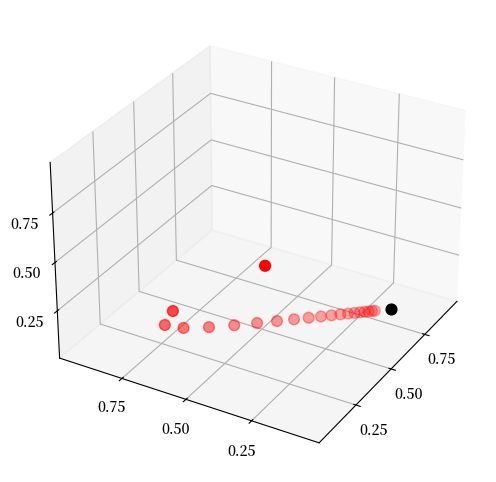

In [22]:
P = ((0.971, 0.029, 0.000),
     (0.145, 0.778, 0.077),
     (0.000, 0.508, 0.492))
P = np.array(P)

ψ = (0.0, 0.2, 0.8)        # 初始条件

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1),
       xticks=(0.25, 0.5, 0.75),
       yticks=(0.25, 0.5, 0.75),
       zticks=(0.25, 0.5, 0.75))

x_vals, y_vals, z_vals = [], [], []
for t in range(20):
    x_vals.append(ψ[0])
    y_vals.append(ψ[1])
    z_vals.append(ψ[2])
    ψ = ψ @ P

ax.scatter(x_vals, y_vals, z_vals, c='r', s=60)
ax.view_init(30, 210)

mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=60)

plt.show()

在这个图中：

* $P$ 是{ref}`上文讨论的 <mc_eg2>`描述经济衰退和增长的随机矩阵
* 最高处的红点代表我们选择的初始概率分布 $\psi$（表示为 $\mathbb R^3$ 中的向量）
* 其余红点表示随时间演化的分布 $\psi P^t$（$t = 1, 2, \ldots$）
* 黑点表示平稳分布 $\psi^*$

你可以尝试更改初始分布，观察系统如何始终收敛到相同的平稳分布。

(ergodicity)=
## {index}`遍历性 <single: Ergodicity>`

```{index} single: 马尔可夫链; 遍历性
```

在不可约性条件下，还有另一个重要的结果：对于所有 $x \in S$，

```{math}
:label: llnfmc0

\frac{1}{m} \sum_{t = 1}^m \mathbf{1}\{X_t = x\}  \to \psi^*(x)
    \quad \text{当 } m \to \infty
```

这里

* $\mathbf{1}\{X_t = x\}$ 是指示函数，当 $X_t = x$ 时等于1，否则等于0
* 收敛是以概率1发生的（也称为"几乎必然"收敛）
* 无论初始状态 $X_0$ 如何分布，这个结果都成立

直观地说，这个结果表明，随着时间的推移，马尔可夫链在状态 $x$ 停留的时间比例将收敛到 $\psi^*(x)$。

(new_interp_sd)=
这给了我们平稳分布的另一种解释方式——它代表了长期内系统在各状态停留的时间比例，前提是{eq}`llnfmc0`中的收敛成立。

{eq}`llnfmc0`实际上是马尔可夫链大数定律的一个特例 — 有兴趣的读者可以参考[EDTC](http://johnstachurski.net/edtc.html)第4.3.4节获取更多细节。

(mc_eg1-2)=
### 示例

让我们回到之前{ref}`讨论过的<mc_eg1-1>`就业/失业模型。

假设 $\alpha \in (0,1)$ 且 $\beta \in (0,1)$，这确保了马尔可夫链的不可约性和非周期性。

我们已经知道平稳分布是 $(p, 1-p)$，其中

$$
p = \frac{\beta}{\alpha + \beta}
$$

从横截面角度看，$p$ 表示整个人口中失业者的比例。

而根据刚才介绍的遍历性结果，$p$ 也表示单个劳动者长期来看处于失业状态的时间占比。

这意味着，从长期来看，群体的横截面平均值与个体的时间序列平均值是一致的。

这正是遍历性的核心含义。

(finite_mc_expec)=
## 计算期望值

```{index} single: 马尔可夫链; 预测未来值
```

我们经常需要计算 $X_t$ 函数的期望值，形式如下：

```{math}
:label: mc_une

\mathbb E [ h(X_t) ]
```

以及条件期望值，如：

```{math}
:label: mc_cce

\mathbb E [ h(X_{t + k})  \mid X_t = x]
```

其中：

* $\{X_t\}$ 是由 $n \times n$ 随机矩阵 $P$ 生成的马尔可夫链
* $h$ 是给定函数，从矩阵代数的角度看，我们将其视为列向量

$$
h
= \left(
\begin{array}{c}
    h(x_1) \\
    \vdots \\
    h(x_n)
\end{array}
  \right)
$$

计算无条件期望值 {eq}`mc_une` 相对简单。

我们只需对 $X_t$ 的边际分布求和即可

$$
\mathbb E [ h(X_t) ]
= \sum_{x \in S} (\psi P^t)(x) h(x)
$$

这里 $\psi$ 是 $X_0$ 的分布。

由于 $\psi$ 以及 $\psi P^t$ 都是行向量，我们也可以简写为

$$
\mathbb E [ h(X_t) ]
=  \psi P^t h
$$

对于条件期望 {eq}`mc_cce`，我们需要对给定 $X_t = x$ 时 $X_{t + k}$ 的条件分布求和。

我们已经知道这个条件分布是 $P^k(x, \cdot)$，因此

```{math}
:label: mc_cce2

\mathbb E [ h(X_{t + k})  \mid X_t = x]
= (P^k h)(x)
```

向量 $P^k h$ 包含了所有状态 $x$ 的条件期望 $\mathbb E [ h(X_{t + k})  \mid X_t = x]$。

### 迭代期望法则

**迭代期望法则**指出

$$
\mathbb E \left[ \mathbb E [ h(X_{t + k})  \mid X_t = x] \right] = \mathbb E [  h(X_{t + k}) ]
$$

其中左边的外部期望 $ \mathbb E$ 是关于 $X_t$ 的边际分布 $\psi_t$ 的（参见方程 {eq}`mdfmc2`）。

为了验证这个法则，我们使用方程 {eq}`mc_cce2` 将 $ (P^k h)(x)$ 代入 $E [ h(X_{t + k})  \mid X_t = x]$，得到

$$
\mathbb E \left[ \mathbb E [ h(X_{t + k})  \mid X_t = x] \right] = \psi_t P^k h,
$$

注意到 $\psi_t P^k h = \psi_{t+k} h = \mathbb E [  h(X_{t + k}) ] $。

### 几何和的期望

有时我们需要计算几何和的期望值，例如 $\sum_t \beta^t h(X_t)$。

根据前面的讨论，对于给定的初始状态 $X_t = x$，这个几何和的条件期望可以表示为

$$
\mathbb{E} \left[
        \sum_{j=0}^\infty \beta^j h(X_{t+j}) \mid X_t = x
    \right]
= [(I - \beta P)^{-1} h](x)
$$

其中

$$
(I - \beta P)^{-1}  = I + \beta P + \beta^2 P^2 + \cdots
$$

乘以 $(I - \beta P)^{-1}$ 相当于应用**预解算子**（resolvent operator）。

## 练习

```{exercise}
:label: fm_ex1

根据{ref}`上述讨论 <mc_eg1-2>`，如果一个劳动者的就业动态遵循随机矩阵

$$
P
= \left(
\begin{array}{cc}
    1 - \alpha & \alpha \\
    \beta & 1 - \beta
\end{array}
  \right)
$$

其中 $\alpha \in (0,1)$ 且 $\beta \in (0,1)$，那么从长期来看，失业时间的比例将是

$$
p := \frac{\beta}{\alpha + \beta}
$$

换句话说，如果 $\{X_t\}$ 表示就业的马尔可夫链，那么当 $m \to \infty$ 时，$\bar X_m \to p$，其中

$$
\bar X_m := \frac{1}{m} \sum_{t = 1}^m \mathbf{1}\{X_t = 0\}
$$

在本练习中，请通过模拟计算大样本量$m$下的 $\bar X_m$ 值，并验证它确实收敛到理论值 $p$。

你会发现，只要参数 $\alpha$ 和 $\beta$ 都严格在 0 和 1 之间，无论从什么初始状态开始，这个收敛结果都成立。
```


```{solution-start} fm_ex1
:class: dropdown
```

让我们通过模拟来验证这个结果。

下面的图表展示了从两种不同初始状态开始时，$\bar X_m - p$ 随时间的变化。

我们可以看到，无论初始状态如何，随着样本量 $m$ 的增加，$\bar X_m$ 都会收敛到理论值 $p$，即 $\bar X_m - p$ 趋近于零。

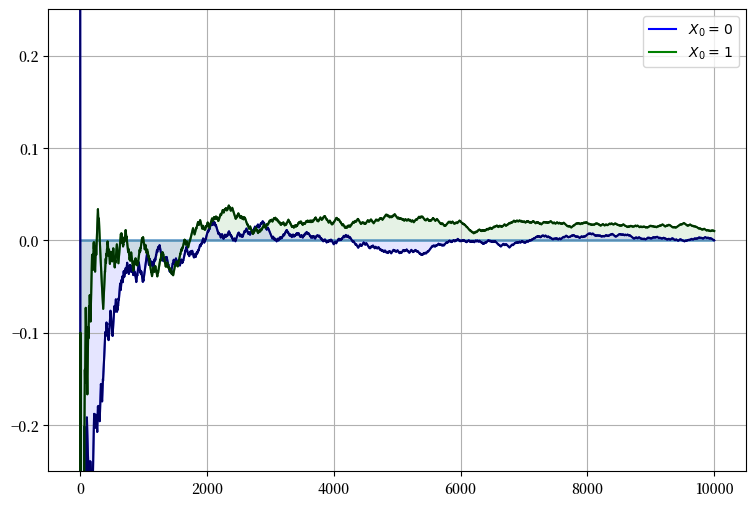

In [23]:
α = β = 0.1
N = 10000
p = β / (α + β)

P = ((1 - α,       α),               # 注意：P和p是不同的
     (    β,   1 - β))
mc = MarkovChain(P)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-0.25, 0.25)
ax.grid()
ax.hlines(0, 0, N, lw=2, alpha=0.6)   # 在零处画水平线

for x0, col in ((0, 'blue'), (1, 'green')):

    # 生成从x0开始的劳动者的时间序列
    X = mc.simulate(N, init=x0)

    # 计算每个n的失业时间比例
    X_bar = (X == 0).cumsum() / (1 + np.arange(N, dtype=float))

    # 绘图
    ax.fill_between(range(N), np.zeros(N), X_bar - p, color=col, alpha=0.1)
    ax.plot(X_bar - p, color=col, label=fr'$X_0 = \, {x0} $')
    ax.plot(X_bar - p, 'k-', alpha=0.6)

ax.legend(loc='upper right')
plt.show()

```{solution-end}
```

```{exercise-start}
:label: fm_ex2
```

*排名*是经济学和众多学科都非常关注的话题。

接下来，我们将探讨一个极其实用且重要的排名问题——搜索引擎如何对网页进行排名。

（虽然这个问题并非源自经济学，但搜索排名系统与某些竞争均衡中的价格机制有着深层次的联系——详见{cite}`DLP2013`。）

要理解这个问题，我们可以思考一下当你在搜索引擎中输入查询时返回的结果。

对于用户来说，理想的搜索体验应该是：

1. 获得大量与查询相关的准确结果
1. 这些结果按照某种"重要性"指标排序呈现

我们现在要讨论的正是如何根据重要性指标对网页进行排名的问题。

Google的创始人拉里·佩奇和谢尔盖·布林为解决这个问题开发了一种方法，这就是著名的[PageRank](https://baike.baidu.com/item/google%20pagerank/2465380)算法。

为了说明这个概念，请看下面的图表

```{figure} /_static/lecture_specific/finite_markov/web_graph.png
```

假设这是一个简化的万维网模型，其中

* 每个节点表示一个网页
* 每个箭头表示一个网页链接到另一个网页

我们来思考一下：什么样的页面才是真正重要的，也就是对搜索引擎用户最有价值的页面？

一个直观的衡量标准是看一个页面有多少入站链接——这在某种程度上反映了它的受欢迎度。

从图中可以看出，`m`和`j`各有5个入站链接，按这个标准应该是最重要的页面。

但这里有个问题：如果链接到`m`的那些页面本身并不重要呢？

这就引出了一个更合理的想法：我们应该根据链接源页面的重要性来给入站链接赋予不同的权重。

这正是PageRank算法的核心思想。

下面我们用一种简化的方式来解释这个算法的基本原理。

假设$j$是任意一个页面，$r_j$是它的排名值，我们定义

$$
r_j = \sum_{i \in L_j} \frac{r_i}{\ell_i}
$$

其中

* $\ell_i$ 是页面 $i$ 的出站链接总数
* $L_j$ 是所有链接到页面 $j$ 的页面集合

这个公式实际上是一个加权的入站链接计数，其中每个链接的权重取决于源页面的重要性（即$r_i$），并通过源页面的出链数量（即$\ell_i$）进行归一化。

这种定义方式自然引导我们回到马尔可夫链的概念。

让我们定义矩阵 $P$，其中 $P(i, j) = \mathbf 1\{i \to j\} / \ell_i$。这里 $\mathbf 1\{i \to j\} = 1$ 表示页面 $i$ 链接到页面 $j$，否则为0。

如果每个页面至少有一个出站链接，那么 $P$ 就是一个随机矩阵。

基于 $P$ 的定义，我们可以重写排名公式：

$$
r_j
= \sum_{i \in L_j} \frac{r_i}{\ell_i}
= \sum_{\text{所有 } i} \mathbf 1\{i \to j\} \frac{r_i}{\ell_i}
= \sum_{\text{所有 } i} P(i, j) r_i
$$

如果我们将排名表示为行向量 $r$，那么上式可以简写为 $r = r P$。

这表明排名向量 $r$ 正是随机矩阵 $P$ 的平稳分布。

从直观上理解，$P(i, j)$ 可以被视为从页面 $i$ "跳转"到页面 $j$ 的概率：

* 如果页面 $i$ 有 $k$ 个出站链接，且其中一个指向 $j$，则 $P(i, j) = 1/k$
* 如果页面 $i$ 没有链接到 $j$，则 $P(i, j) = 0$

这描述了一个网络浏览者的随机漫步过程——在每个页面上随机点击一个链接继续浏览。

由于 $r$ 是 $P$ 的平稳分布，假设一致遍历性成立，我们可以{ref}`解读 <new_interp_sd>` $r_j$ 为一个长期随机浏览者在页面 $j$ 上停留的时间比例。

你的练习是将这个排名算法应用到上图所示的网络中，并按排名从高到低列出所有页面。

图中共有14个节点（网页），分别标记为 `a` 到 `n`。

数据文件中的每一行具有以下格式：

```{code-block} none
d -> h;
```

这说明了存在一个从`d`到`h`的链接。

下面显示了这个图的数据，当单元格执行时，这些数据被读入名为`web_graph_data.txt`的文件中。

In [24]:
%%file web_graph_data.txt
a -> d;
a -> f;
b -> j;
b -> k;
b -> m;
c -> c;
c -> g;
c -> j;
c -> m;
d -> f;
d -> h;
d -> k;
e -> d;
e -> h;
e -> l;
f -> a;
f -> b;
f -> j;
f -> l;
g -> b;
g -> j;
h -> d;
h -> g;
h -> l;
h -> m;
i -> g;
i -> h;
i -> n;
j -> e;
j -> i;
j -> k;
k -> n;
l -> m;
m -> g;
n -> c;
n -> j;
n -> m;

Overwriting web_graph_data.txt


要解析这个文件并提取相关信息，你可以使用[正则表达式](https://docs.python.org/3/library/re.html)。

下面的代码片段提供了一个关于如何实现的提示

In [25]:
import re
re.findall(r'\w', 'x +++ y ****** z')  # \w 匹配字母数字字符

['x', 'y', 'z']

In [26]:
re.findall(r'\w', 'a ^^ b &&& $$ c')

['a', 'b', 'c']

当你解出排名时，你会发现实际上`g`是排名最高的节点，而`a`是排名最低的。

```{exercise-end}
```


```{solution-start} fm_ex2
:class: dropdown
```

这是一个解决方案：

In [27]:
"""
返回按排名排序的页面列表
"""
import re
from operator import itemgetter

infile = 'web_graph_data.txt'
alphabet = 'abcdefghijklmnopqrstuvwxyz'

n = 14 # 网页（节点）总数

# 创建一个表示链接存在的矩阵Q
#  * Q[i, j] = 1 表示从i到j存在链接
#  * Q[i, j] = 0 表示不存在链接
Q = np.zeros((n, n), dtype=int)
with open(infile) as f:
    edges = f.readlines()
for edge in edges:
    from_node, to_node = re.findall(r'\w', edge)
    i, j = alphabet.index(from_node), alphabet.index(to_node)
    Q[i, j] = 1

# 创建相应的马尔可夫矩阵P
P = np.empty((n, n))
for i in range(n):
    P[i, :] = Q[i, :] / Q[i, :].sum()
mc = MarkovChain(P)

# 计算平稳分布r
r = mc.stationary_distributions[0]
ranked_pages = {alphabet[i] : r[i] for i in range(n)}

# 输出解，从最高排名到最低排名排序
print(r'排名\n ***')
for name, rank in sorted(ranked_pages.items(), key=itemgetter(1), reverse=1):
    print(f'{name}: {rank:.4}')

排名\n ***
g: 0.1607
j: 0.1594
m: 0.1195
n: 0.1088
k: 0.09106
b: 0.08326
e: 0.05312
i: 0.05312
c: 0.04834
h: 0.0456
l: 0.03202
d: 0.03056
f: 0.01164
a: 0.002911


```{solution-end}
```


```{exercise}
:label: fm_ex3

在数值计算中，有时用离散模型替代连续模型会比较方便。

特别是，马尔可夫链经常被用作如下AR(1)过程的离散近似：

$$
y_{t+1} = \rho y_t + u_{t+1}
$$

这里假设${u_t}$是独立同分布的，且服从$N(0, \sigma_u^2)$。

$\{ y_t \}$的平稳概率分布的方差为

$$
\sigma_y^2 := \frac{\sigma_u^2}{1-\rho^2}
$$

Tauchen方法{cite}`Tauchen1986`是将这个连续状态过程近似为有限状态马尔可夫链最常用的方法。

[QuantEcon.py](http://quantecon.org/quantecon-py)中已经有了这个程序，但让我们作为练习自己写一个版本。

作为第一步，我们选择：

* $n$，离散近似的状态数
* $m$，一个用于参数化状态空间宽度的整数

接下来，我们创建一个状态空间$\{x_0, \ldots, x_{n-1}\} \subset \mathbb R$

以及一个随机 $n \times n$ 矩阵 $P$，满足以下条件：

* $x_0 = - m \, \sigma_y$
* $x_{n-1} = m \, \sigma_y$
* $x_{i+1} = x_i + s$ 其中 $s = (x_{n-1} - x_0) / (n - 1)$

令 $F$ 为正态分布 $N(0, \sigma_u^2)$ 的累积分布函数。

$P(x_i, x_j)$ 的值是为了近似 AR(1) 过程而计算的 --- 省略推导过程，规则如下：

1. 如果 $j = 0$，则设

   $$
   P(x_i, x_j) = P(x_i, x_0) = F(x_0-\rho x_i + s/2)
   $$

1. 如果 $j = n-1$，则设

   $$
   P(x_i, x_j) = P(x_i, x_{n-1}) = 1 - F(x_{n-1} - \rho x_i - s/2)
   $$

1. 否则，设

   $$
   P(x_i, x_j) = F(x_j - \rho x_i + s/2) - F(x_j - \rho x_i - s/2)
   $$

练习要求编写一个函数 `approx_markov(rho, sigma_u, m=3, n=7)`，返回
$\{x_0, \ldots, x_{n-1}\} \subset \mathbb R$ 和 $n \times n$ 矩阵
$P$，如上所述。

* 更好的方法是编写一个函数，返回[QuantEcon.py](http://quantecon.org/quantecon-py)的MarkovChain类的实例。
```

```{solution} fm_ex3
:class: dropdown

可以在[QuantEcon.py](http://quantecon.org/quantecon-py)库中找到解决方案，
具体可见[这里](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/markov/approximation.py)。

```

[^pm]: 提示：首先证明如果P和Q是随机矩阵，那么它们的乘积也是随机矩阵——要检查行和，试着用一列1向量进行后乘。最后，用归纳法论证P^n是随机矩阵。